In [1]:
# Install required packages
# Uncomment and run these lines if you haven't installed these packages yet

#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install torch torchvision torchaudio


In [2]:
from IPython.display import Image, display

# Part 1: Conceptual Understanding of Pipeline Schedules

1. In pipeline parallelism, a bubble is any point of the computation where the GPU(s) are idle and do not have any forward or backward calculations to perform. The image below (from slides) motivates more advanced parallelism methods and shows the primitive method of passing only one entire batch through the pipeline stages (any one GPU is active at a given point). One can clearly see how idle device 0 is while it waits to compute the gradients for the batch.

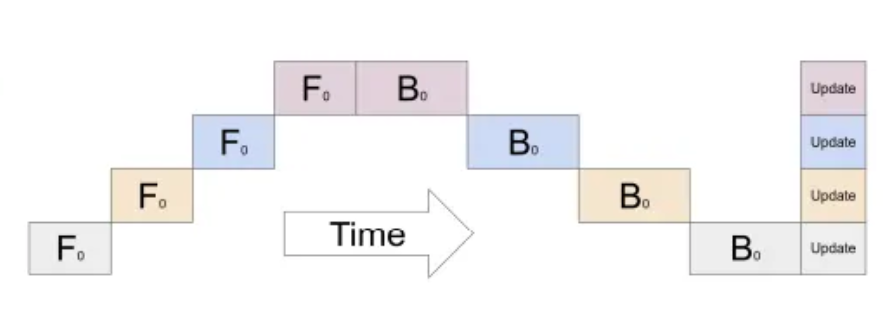

In [3]:
display(Image('./bubble.png'))

1 continued. GPipe addresses the problem by breaking a larger batch into mini batches and passing them through the different pipeline stages such that each GPU works on a different mini-batch parallelly. This clearly reduces the idle time. 1F1B goes even further and alternates forward and backward pass for each device after an intial warm up period to reduce the idle time even further while optimzing for memory (all activation states don't need to be stored like in GPipe). Interleaved 1F1B is the most advanced out of the 3 and it reduces the bubble even futher by assigning each device multiple non-contiguous sets of layers (model chunks) rather than a continuous set of layers like we would before. Therefore each device handles more stages.

Qualitative Analysis for each (time on horizontal axis in the images):

GPipe: The bubble overhead is the region in the middle where the consecutive grey blocks show the idle time for a specific device. Because Gpipe waits to compute all forward computations for the mini batches before backward computations, there is a non-trivial bubble. Device 1 waits especially long

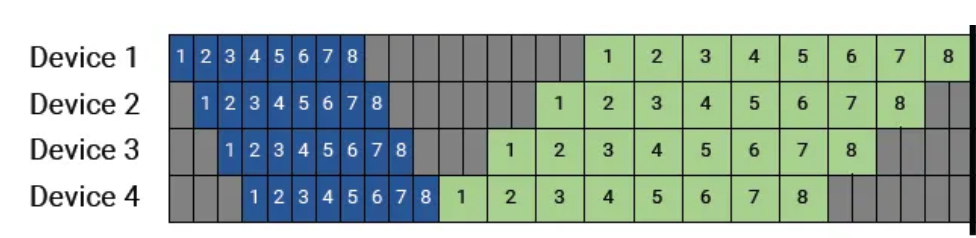

In [4]:
display(Image('./gpipe.png'))

1F1B: Instead of waiting to finish all forward computations, 1f1b starts the backward for mini batch 1 as soon as it is done with the forward for the same (this is the warm up) and then continues alternating for other forwards, significantly reducing the bubble/idle by allowing the backward computations to reach earlier devices faster (which also alternate and hence reduce idle time).

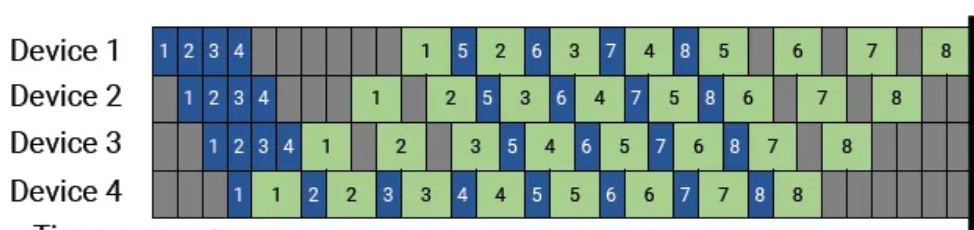

In [5]:
display(Image('./1f1b.png'))

Interleaved 1F1B: This goes even further by assigning multiple non consecutive model layers to each device (multiple stages per device). hence, computation time for each stage goes down with the idle time cause of the greater flexibility in interleaving the microbatches through the more granular batches. Hence, almost negligible idle time and very time efficient.

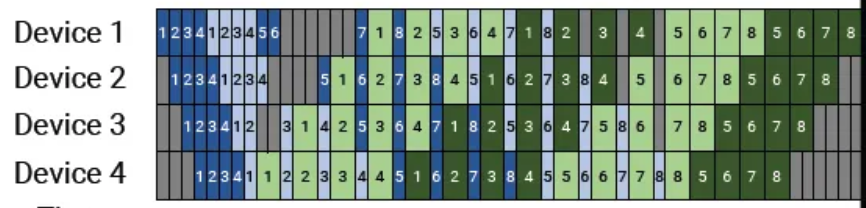

In [6]:
display(Image('./interleave.png'))

2. 1F1B interleaved is a pipeline schedule where each pipeline stage is broken into multiple smaller stages (smaller non consecutive "model chunks"). It then runs the usual 1F1B schedule at the sub stage level, interleaving between these sub-stages on the same GPU. The key innovation is that we are interleaving between the mini stages during both forward and backward in addition to alternating between forwards and backwards. A rank bascially refers to a process linked to a specific GPU and hence "multiple stages per rank" refers to the different "model chucks" that reside in each process/ GPU. As mentioned before, this improves pipeline efficiency by keeping the rank occupied a higher percentage of the time with smaller more time efficient stages.

# Part 2: Implementation and Performance Evaluation

### Prereqs
1. **Activate conda environment**

2. **Install required packages:**
   - uncomment and run pip install commands in the very first cell


In [7]:
# All imports
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.multiprocessing as mp

from typing import Dict
import warnings
warnings.filterwarnings('ignore')

# import pipeline utilities from external module (required for multiprocessing)
from LLMsHW2Prob1Helper import ModelArgs, Transformer, manual_model_split, run_train_iterations, worker_process

## Pipeline Parallelism Implementation and Performance Evaluation

### Setup and Hardware Specifications

**Hardware Configuration:**
- Device: CPU-based training (no GPU available) as I could not get access to a multi-GPU environment. I even contacted Google sales and they could not increase my GPU quota. The differences in performance will be touched upon later. 
- CPU Cores: Available for parallel processing and number shown in the next cell
- PyTorch Version: Displayed below

**Files for Problem:**
- `LLMsHW2Prob1.ipynb` - Main notebook that executes the experiments to generate data
- `LLMsHW2Prob1Helper.py` - Helper module with multiprocessing functions, the simple transformer model, and the manual model split function

**Note on CPU vs GPU:**
- The implementation uses CPU with `gloo` backend instead of GPU with `nccl` backend, hence the CPU training will be significantly slower compared to that of a GPU
- communication overhead between parallel processes is much higher on CPU cores compared to a multi-GPU setup(networks like NVlink are much more optimized for communication for parallel workloads)
- More processes = more pipeline stages = potentially more parallelism but more processes aren't technical parallel as parallel as they would be on a GPU
- Hence, on GPUs, we would expect higher throughput and better scaling efficiency

**Technical Note:**
- Functions used by multiprocessing workers are in `LLMsHW2Prob1Helper.py` to avoid pickle errors in Jupyter
- Please check comments/markdown for more information about the functions and their adaptations for the task at hand. The helper functions are described in the other file. Results are discussed at the end


In [8]:
# Resource Run down
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CPU Count: {os.cpu_count()}")

PyTorch Version: 2.8.0
CUDA Available: False
CPU Count: 10


model classes are imported from a .py file. This is required for multiprocessing to work in jupyter notebooks, as each worker/ "spawn" 
creates a completely fresh Python interpreter and each one of these processes needs to import the functions in the file (not possible if the file is ipynb)

### Training and Metrics Collection

Functions for running training iterations and collecting performance metrics. These are not in the tutorial.

**Implementation Notes:**

**Schedule Differences:**
- `ScheduleGPipe` and `Schedule1F1B`: 1 stage per worker (traditional pipeline)
- `ScheduleInterleaved1F1B`: **2 stages per worker** (virtual pipeline parallelism)

**Virtual Pipeline Parallelism:**
- Interleaved1F1B uses 2 stages per worker when `n_layers % (num_workers × 2) == 0` and falls back to 1 stage per worker otherwise
- Each worker holds multiple non-continuous model chunks

**Configuration Results:**
- Given the above stage structure for interleaved, there are configurations where Interleaved has to default to 1 stage per worker:
- 4, 12 layers with 4 workers (in which case the algo becomes the same as 1F1B)


In [9]:
# run a single experiment
# sequence length is reduced for CPU for fastr training times
# this was not in the tutorial and was added to handle process spawning and metric collection (however it does take some code from the main execution and distrtibuted initialization)

def run_one_experiment(n_layers: int, n_heads: int, num_processes: int, schedule_type: str, batch_size: int = 32, seq_length: int = 128, num_iterations: int = 10) -> Dict:
    """
    run a single experiment configuration.
    """
    # run distributed training where each worker independently runs its own helper function script
    ctx = mp.get_context('spawn')
    results_queue = ctx.Queue()
    
    processes = []
    for rank in range(num_processes):
        p = ctx.Process(
            target=worker_process, 
            args=(rank, num_processes, n_layers, n_heads, schedule_type,
                  batch_size, seq_length, num_iterations, results_queue)
        )
        p.start()
        processes.append(p)
    
    for p in processes:
        p.join()
    
    # gather results
    if not results_queue.empty():
        results = results_queue.get()
    else:
        results = {'error': 'No results returned'}
    
    return results

In [10]:
# run all experiments
# again not present in the tutorial and cycles through all configurations to store the metrics that are used in the results
def run_all_experiments():
    heads = [4, 8, 12]
    layers = [4, 8, 12]
    processes = [2, 4]
    schedules = ['GPipe', '1F1B', 'Interleaved1F1B']
    
    results = []
    total_exps = len(layers) * len(heads) * len(processes) * len(schedules)
    exp_count = 0
    
    print(f"Total experiments to run: {total_exps}\n")
    
    for n_layers in layers:
        for n_heads in heads:
            for num_processes in processes:
                for schedule in schedules:
                    exp_count += 1
                    print(f"[{exp_count}/{total_exps}] Running: "
                          f"Layers={n_layers}, Heads={n_heads}, "
                          f"Processes={num_processes}, Schedule={schedule}")
                    
                    try:
                        metrics = run_one_experiment(
                            n_layers=n_layers, 
                            n_heads=n_heads, 
                            num_processes=num_processes, 
                            schedule_type=schedule, 
                            num_iterations=5
                        )
                        
                        if 'error' not in metrics:
                            results.append({
                                'n_layers': n_layers,
                                'n_heads': n_heads,
                                'num_processes': num_processes,
                                'schedule': schedule,
                                'throughput': metrics['throughput'],
                                'elapsed_time': metrics['elapsed_time'],
                                'tokens_processed': metrics['tokens_processed']
                            })
                            print(f"Throughput: {metrics['throughput']:.2f} tokens/sec\n")
                        else:
                            print(f"Error: {metrics['error']}\n")
                    except Exception as e:
                        print(f"Exception: {e}\n")
                        continue
    
    return pd.DataFrame(results)

In [11]:
# func to compute speedup and efficiency. again not in the tutorial and formula given in the problem set
# Speedup = Throughput_schedule / Throughput_GPipe
# Efficiency = (Speedup / num_processes) * 100%
def compute_speedup_and_efficiency(df: pd.DataFrame) -> pd.DataFrame:
    results = []
    
    # for each combination of the configurable parameters, calculate the speedup and efficiency for 
    # f1b1 flavors
    for (n_layers, n_heads, num_processes), group in df.groupby(['n_layers', 'n_heads', 'num_processes']):
        gpipe_throughput = group[group['schedule'] == 'GPipe']['throughput'].values
        
        if len(gpipe_throughput) == 0:
            continue
        gpipe_throughput = gpipe_throughput[0]
        
        for schedule in ['1F1B', 'Interleaved1F1B']:
            schedule_data = group[group['schedule'] == schedule]
            if len(schedule_data) > 0:
                throughput = schedule_data['throughput'].values[0]
                speedup = throughput / gpipe_throughput
                efficiency = (speedup / num_processes) * 100
                
                results.append({
                    'n_layers': n_layers,
                    'n_heads': n_heads,
                    'num_processes': num_processes,
                    'schedule': schedule,
                    'speedup': speedup,
                    'efficiency': efficiency
                })
    
    return pd.DataFrame(results)


### Experiment Layout

Running experiments with the following parameters:
- **Schedules:** GPipe, 1F1B, Interleaved1F1B
- **Layers:** 4, 8, 12
- **Attention Heads:** 4, 8, 12
- **Number of Processes:** 2, 4
- **Batch Size:** 32 (constant)
- **Sequence Length:** 128 (constant, reduced for CPU)
- **Training Iterations:** 5 per experiment
- **Total Experiments:** 54 (3 schedules × 3 layer configs × 3 head configs × 2 process configs)


In [12]:
# run all configs
print("Starting experiments...\n")
df_results = run_all_experiments()

# save results
print("\n" + "="*50)
print("EXPERIMENTS COMPLETE!")
print("="*50)
print(f"\successful experiments: {len(df_results)}")


Starting experiments...

Total experiments to run: 54

[1/54] Running: Layers=4, Heads=4, Processes=2, Schedule=GPipe


Throughput: 3154.76 tokens/sec

[2/54] Running: Layers=4, Heads=4, Processes=2, Schedule=1F1B
Throughput: 3238.24 tokens/sec

[3/54] Running: Layers=4, Heads=4, Processes=2, Schedule=Interleaved1F1B
Throughput: 3278.79 tokens/sec

[4/54] Running: Layers=4, Heads=4, Processes=4, Schedule=GPipe
Throughput: 3606.48 tokens/sec

[5/54] Running: Layers=4, Heads=4, Processes=4, Schedule=1F1B
Throughput: 3722.89 tokens/sec

[6/54] Running: Layers=4, Heads=4, Processes=4, Schedule=Interleaved1F1B
Throughput: 3545.62 tokens/sec

[7/54] Running: Layers=4, Heads=8, Processes=2, Schedule=GPipe
Throughput: 3051.49 tokens/sec

[8/54] Running: Layers=4, Heads=8, Processes=2, Schedule=1F1B
Throughput: 2995.72 tokens/sec

[9/54] Running: Layers=4, Heads=8, Processes=2, Schedule=Interleaved1F1B
Throughput: 3219.27 tokens/sec

[10/54] Running: Layers=4, Heads=8, Processes=4, Schedule=GPipe
Throughput: 3333.58 tokens/sec

[11/54] Running: Layers=4, Heads=8, Processes=4, Schedule=1F1B
Throughput: 3541.49 to

### Results Display


In [13]:
# show results table which mainly includes throughput and timings
print("\n" + "="*50)
print("EXPERIMENT RESULTS")
print("="*50)
print(df_results.to_string(index=False))

# pivot tables for better visualization
print("\n" + "-"*50)
print("Average Throughput (tokens/sec) by Configuration:")
print("-"*50)
pivot_throughput = df_results.pivot_table(
    values='throughput',
    index=['n_layers', 'n_heads'],
    columns=['schedule', 'num_processes'],
    aggfunc='mean'
)
print(pivot_throughput)



EXPERIMENT RESULTS
 n_layers  n_heads  num_processes        schedule  throughput  elapsed_time  tokens_processed
        4        4              2           GPipe 3154.756913      6.491784             20480
        4        4              2            1F1B 3238.242721      6.324418             20480
        4        4              2 Interleaved1F1B 3278.790208      6.246206             20480
        4        4              4           GPipe 3606.475900      5.678674             20480
        4        4              4            1F1B 3722.888515      5.501105             20480
        4        4              4 Interleaved1F1B 3545.616788      5.776146             20480
        4        8              2           GPipe 3051.487401      6.711481             20480
        4        8              2            1F1B 2995.724866      6.836409             20480
        4        8              2 Interleaved1F1B 3219.272862      6.361685             20480
        4        8              4       

In [14]:
# speedup and efficiency metrics
df_speedup = compute_speedup_and_efficiency(df_results)

print("\n" + "="*50)
print("SPEEDUP AND EFFICIENCY ANALYSIS")
print("="*50)
print("\nSpeedup and Efficiency (relative to GPipe):")
print(df_speedup.to_string(index=False))


SPEEDUP AND EFFICIENCY ANALYSIS

Speedup and Efficiency (relative to GPipe):
 n_layers  n_heads  num_processes        schedule  speedup  efficiency
        4        4              2            1F1B 1.026463   51.323173
        4        4              2 Interleaved1F1B 1.039316   51.965814
        4        4              4            1F1B 1.032279   25.806969
        4        4              4 Interleaved1F1B 0.983125   24.578126
        4        8              2            1F1B 0.981726   49.086306
        4        8              2 Interleaved1F1B 1.054985   52.749241
        4        8              4            1F1B 1.062368   26.559211
        4        8              4 Interleaved1F1B 1.022807   25.570171
        4       12              2            1F1B 1.022914   51.145691
        4       12              2 Interleaved1F1B 1.042560   52.128017
        4       12              4            1F1B 1.022712   25.567806
        4       12              4 Interleaved1F1B 0.995849   24.896226

### Speedup and Efficiency Plots

Plot speedup and scaling efficiency for 1F1B and Interleaved1F1B schedules relative to GPipe baseline across all model configurations.


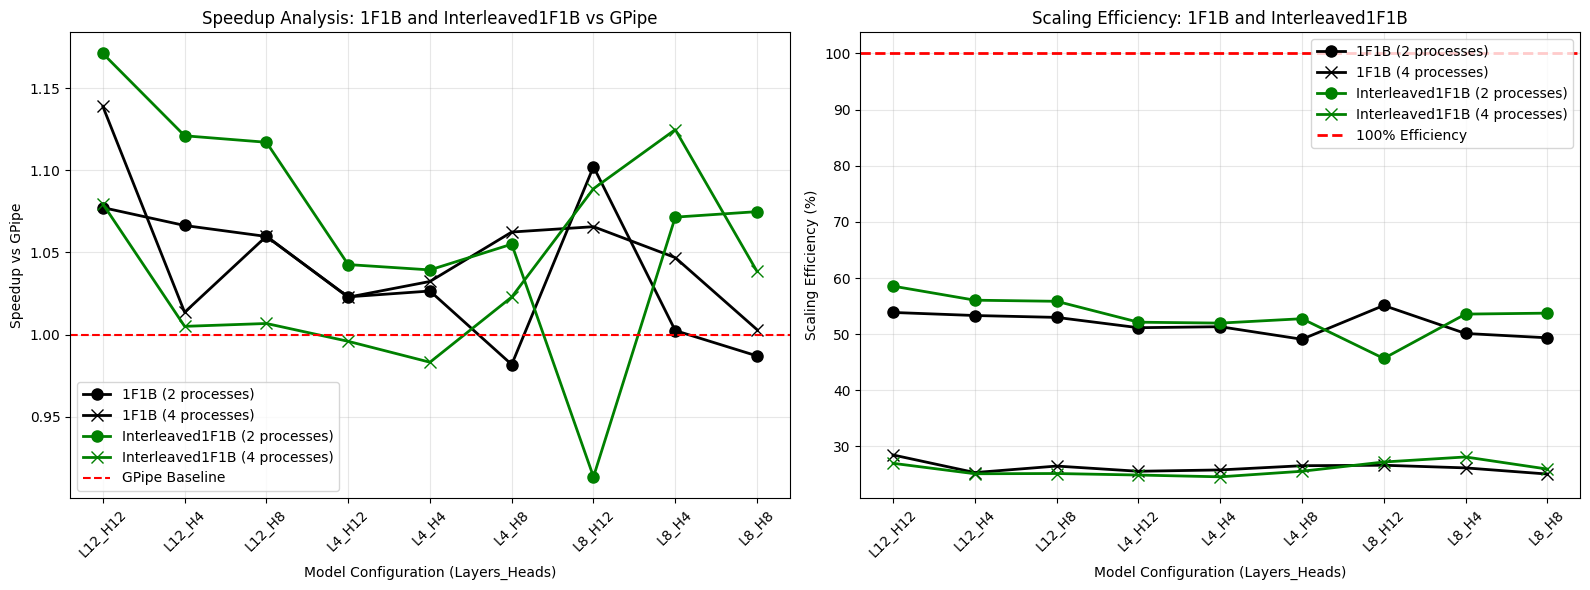

In [17]:
# speedup and efficiency plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# model configuration labels
df_speedup['model_config'] = df_speedup.apply(
    lambda row: f"L{row['n_layers']}_H{row['n_heads']}", axis=1
)

schedules = ['1F1B', 'Interleaved1F1B']
colors = {'1F1B': 'black', 'Interleaved1F1B': 'green'}
markers = {2: 'o', 4: 'x'}

# speedup plot
ax = axes[0]
for schedule in schedules:
    for num_processes in [2, 4]:
        data = df_speedup[
            (df_speedup['schedule'] == schedule) & 
            (df_speedup['num_processes'] == num_processes)
        ].sort_values('model_config')
        
        ax.plot(data['model_config'], data['speedup'], 
                marker=markers[num_processes], 
                label=f"{schedule} ({num_processes} processes)",
                color=colors[schedule],
                linewidth=2,
                markersize=8)

ax.axhline(y=1.0, color='red', linestyle='--', label='GPipe Baseline')
ax.set_xlabel('Model Configuration (Layers_Heads)')
ax.set_ylabel('Speedup vs GPipe')
ax.set_title('Speedup Analysis: 1F1B and Interleaved1F1B vs GPipe')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# plot of efficiency
ax = axes[1]
for schedule in schedules:
    for num_processes in [2, 4]:
        data = df_speedup[
            (df_speedup['schedule'] == schedule) & 
            (df_speedup['num_processes'] == num_processes)
        ].sort_values('model_config')
        
        ax.plot(data['model_config'], data['efficiency'], 
                marker=markers[num_processes], 
                label=f"{schedule} ({num_processes} processes)",
                color=colors[schedule],
                linewidth=2,
                markersize=8)

ax.axhline(y=100.0, color='red', linestyle='--', label='100% Efficiency', linewidth=2)
ax.set_xlabel('Model Configuration (Layers_Heads)')
ax.set_ylabel('Scaling Efficiency (%)')
ax.set_title('Scaling Efficiency: 1F1B and Interleaved1F1B')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Throughput Plots

Compare throughput across different schedules for various model configurations.


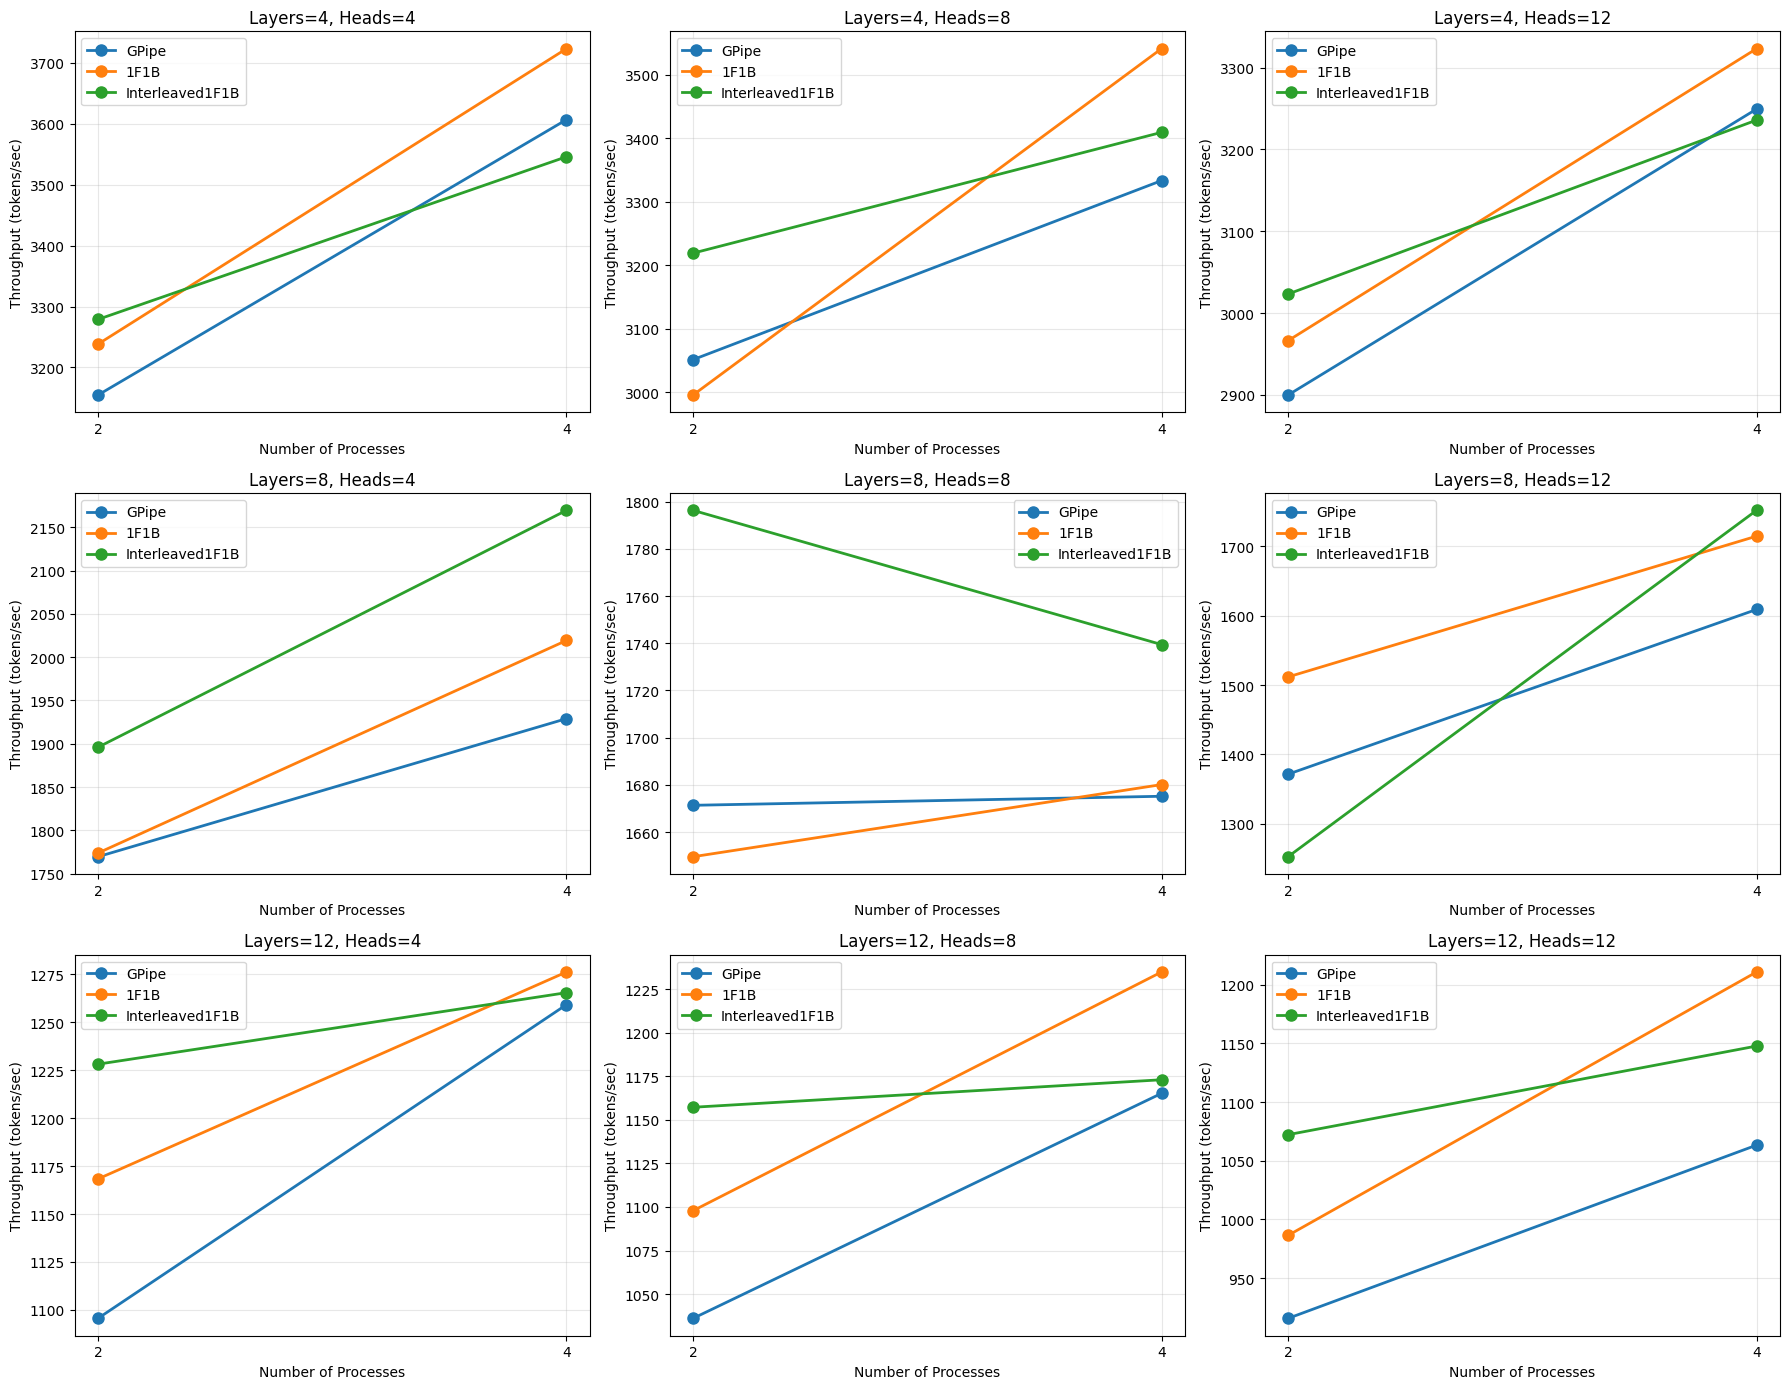

In [16]:
# throughput comparison plots for different configurations
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# all 9 model configs (3 layers × 3 heads) - num processes will be along the x-axis
configs = [(4, 4), (4, 8), (4, 12), (8, 4), (8, 8), (8, 12), (12, 4), (12, 8), (12, 12)]

for idx, (n_layers, n_heads) in enumerate(configs):
    ax = axes[idx]
    
    # filter data for this configuration
    data = df_results[
        (df_results['n_layers'] == n_layers) & 
        (df_results['n_heads'] == n_heads)
    ]
    
    # plot each schedule
    for schedule in ['GPipe', '1F1B', 'Interleaved1F1B']:
        schedule_data = data[data['schedule'] == schedule].sort_values('num_processes')
        ax.plot(schedule_data['num_processes'], schedule_data['throughput'],
                marker='o', label=schedule, linewidth=2, markersize=8)
    
    ax.set_xlabel('Number of Processes')
    ax.set_ylabel('Throughput (tokens/sec)')
    ax.set_title(f'Layers={n_layers}, Heads={n_heads}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks([2, 4])

plt.tight_layout()
plt.show()


### Result Analysis

1. Which schedule performs best for different model configurations? Why?

Looking at the plots above, interleaved 1f1b consistently beats 1f1b and Gpipe in most cases where we were able to fit 2 stages per device for interleaved (remember that num_layers%(num_workers*2) must equal 0 for multiple stages per device). In these cases, interleaved could effectively use its more advacned scheduling to reduce the bubble and increase throughput as seen above. In cases where we couldn't fit an integer number of layers (just 1 stage per device), we should default to 1f1b as that consistently performs better (example of this is 12 layers and 4 devices/workers). It's a more light weight algorithm and intended to be used with 1 stage per device. if one is working with a much smaller model and need an easier to understand implementation, they can use Gpipe as the throughputs (although lower) are not so different.


2. How does performance scale with increasing model size (layers and heads)?

Looking purely at throughput, it generally reduces as the model size increases (cause of the larger time elapsed). However, as seen in the speedup plot, the relative performace does increase as the model size increases. this is more noticeable towards the left side of the plot where speedup generally increases for both 1f1b schedules as the number of layers and heads increase. This makes sense as the larger models require more computation per microbatch and it makes sense that the more advaced schedules outperform Gpipe by a larger margin. Unsurprisingly, scaling efficiency reduced for both schedules going from 2 to 4 processes and this is expected as performance doesn't scale as fast as the communication overhead. This is more true for this assingment's CPU setup where the drop off in efficiency is probably larger compoared to that of a multi-GPU system considered the huge overhead.


#### Reproducibility

- **Random Seed:** Not set (stochastic variation in timings)
- **PyTorch Version:** See system info above
- **Backend:** GLOO (CPU-based distributed)
- **Hardware:** CPU-only training
- **Batch Size:** 32, Sequence Length: 128
- **Microbatches:** 4 per batch


### References

- PyTorch Pipeline Parallelism Tutorial: https://pytorch.org/tutorials/intermediate/pipelining_tutorial.html
- GPipe Paper: https://arxiv.org/abs/1811.06965
- PipeDream (1F1B): https://arxiv.org/abs/1806.03377
- Medium: https://medium.com/byte-sized-ai/pipeline-parallelism-explained-in-2-mins-6bdf1ab29053
